# Facebook Friend Recommender

First we will load our dataset from Kaggle and perform exploratory data analysis on our given data set such as number of followers and followees of each person. Then we will generate some datapoints which were not present in our given data-set, since we have only class label 1 data. Then we will do some feature engineering on dataset like finding shortest path, kartz centrality, jaccard distances, page rank, preferential attachements etc. After performing exploratory data analysis and feature engineering, we will split whole dataset into train and test and perform random forest and xgboost taking f1-score as our metric. At the end we will plot confusion matrix and pretty-table for both algorithm and finf best hyperparameters.

## Setup

In [ ]:
import math
import random
import pickle
import os
import csv
import pandas as pd
import datetime
import time
import numpy as np

import matplotlib
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import xgboost as xgb
import networkx as nx
import pdb
import pickle

import warnings
warnings.filterwarnings("ignore")

## Load dataset

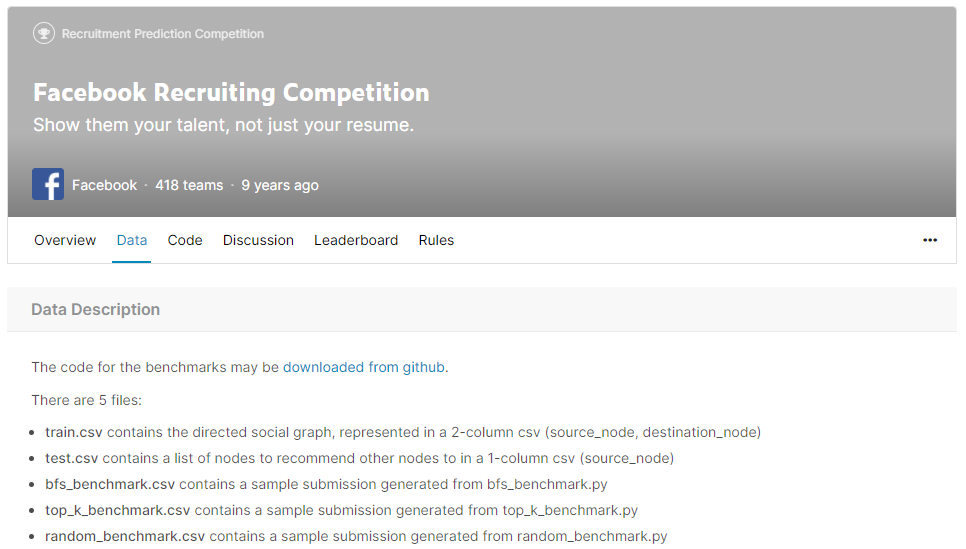

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c FacebookRecruiting

     |████████████████████████████████| 58 kB 4.5 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=940b16c3e71a3ef30f3c537442dadc0e4ad95f67fd31f490151951ac308ec731
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 84% 161M/191M [00:04<00:01, 26.3MB/s]
100% 191M/191M [00:04<00:00, 42.8MB/s]


In [ ]:
!unzip FacebookRecruiting.zip

Archive:  FacebookRecruiting.zip
  inflating: bfs_benchmark.csv       
  inflating: random_benchmark.csv    
  inflating: test.csv                
  inflating: train.7z                
  inflating: train.csv               
  inflating: train.gz                
  inflating: train.zip               


## Reading graph

In [ ]:
traincsv = pd.read_csv('train.csv')
traincsv.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [ ]:
traincsv.describe()

,source_node,destination_node
count,9.437519e+06,9.437519e+06
mean,9.306740e+05,9.312252e+05
std,5.383368e+05,5.380682e+05
min,1.000000e+00,1.000000e+00
25%,4.638685e+05,4.647640e+05
50%,9.303910e+05,9.316830e+05
75%,1.397245e+06,1.397560e+06
max,1.862220e+06,1.862220e+06


In [ ]:
print(traincsv[traincsv.isna().any(1)])
print(traincsv.info())
print("Number of diplicate entries: ",sum(traincsv.duplicated()))
traincsv.to_csv('train_woheader.csv',header=False,index=False)
print("saved the graph into file")

Empty DataFrame
Columns: [source_node, destination_node]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB
None
Number of diplicate entries:  0
saved the graph into file


In [ ]:
g = nx.read_edgelist('train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Name: 
Type: DiGraph
Number of nodes: 26
Number of edges: 20
Average in degree:   0.7692
Average out degree:   0.7692


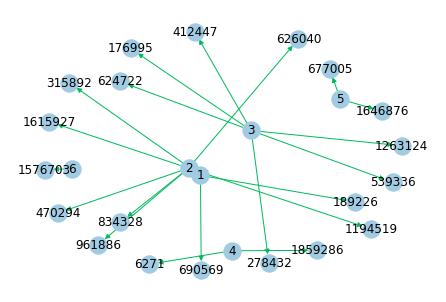

In [ ]:
traincsv.head(20).to_csv('train_woheader_sample.csv',header=False,index=False)
    
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
# https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib

pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

## Exploratory data analysis

In [ ]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


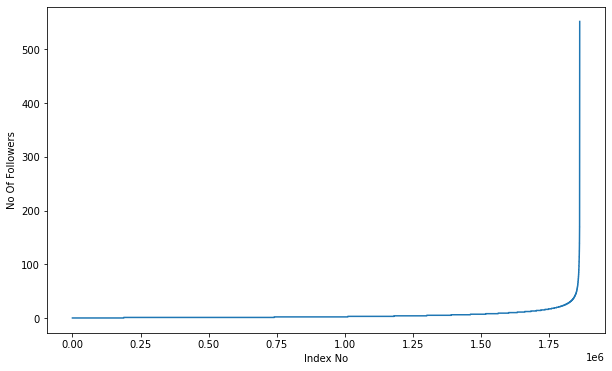

In [ ]:
# No of followers of each person
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

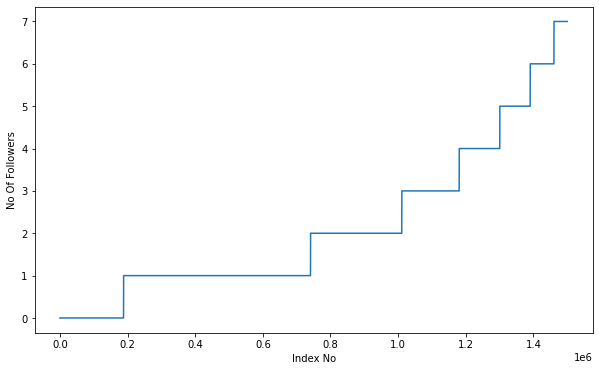

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

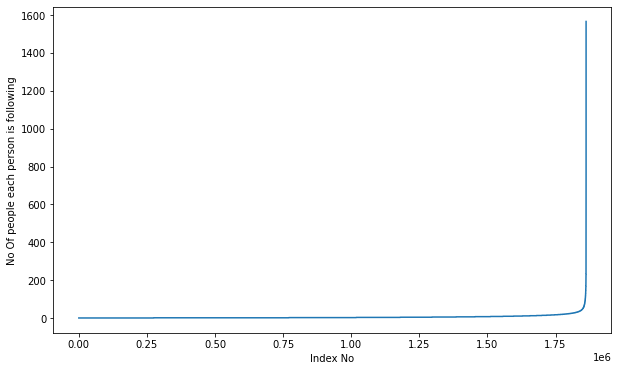

In [ ]:
# No Of people each person is following
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
print('No of persons who are not following anyone are {} ({:.2%})'.format(sum(np.array(outdegree_dist)==0),
                                                                        sum(np.array(outdegree_dist)==0)/len(outdegree_dist)))

No of persons who are not following anyone are 274512 (14.74%)


In [ ]:
print('No of persons having zero followers are {} ({:.2%})'.format(sum(np.array(indegree_dist)==0),
                                                                        sum(np.array(indegree_dist)==0)/len(indegree_dist)))

No of persons having zero followers are 188043 (10.10%)


In [ ]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not following anyone and also not having any followers are',count)

No of persons those are not following anyone and also not having any followers are 0


## Negative sampling

Generating some edges which are not present in graph for supervised learning. In other words, we are generating bad links from graph which are not in graph and whose shortest path is greater than 2.

In [ ]:
r = csv.reader(open('train_woheader.csv','r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1
missing_edges = set([])

with tqdm(total=9437519) as pbar:
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)    
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
        pbar.update(1)
pickle.dump(missing_edges,open('missing_edges_final.p','wb'))

In [ ]:
list(missing_edges)[:10]

[(885577, 1583706),
 (1487373, 176918),
 (1796282, 916021),
 (167023, 569005),
 (1204330, 1443051),
 (823309, 780941),
 (731061, 1684320),
 (283674, 455265),
 (412300, 691150),
 (586754, 854524)]

## Train/test split

> Tip: We will split positive links and negative links seperatly because we need only positive training data for creating graph and for feature generation.

In [ ]:
#reading total data df
df_pos = pd.read_csv('train.csv')
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])

#Trian test split 
#Spiltted data into 80-20
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

#removing header and saving
X_train_pos.to_csv('train_pos_after_eda.csv',header=False, index=False)
X_test_pos.to_csv('test_pos_after_eda.csv',header=False, index=False)
X_train_neg.to_csv('train_neg_after_eda.csv',header=False, index=False)
X_test_neg.to_csv('test_neg_after_eda.csv',header=False, index=False)

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


In [ ]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph=nx.read_edgelist('test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))
print(nx.info(test_graph))

# finding the unique nodes in both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print('no of people common in train and test -- ',trY_teY)
print('no of people present in train but not present in test -- ',trY_teN)
print('no of people present in test but not present in train -- ',teY_trN)
print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399
Name: 
Type: DiGraph
Number of nodes: 1144623
Number of edges: 1887504
Average in degree:   1.6490
Average out degree:   1.6490
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


In [ ]:
X_train_pos = pd.read_csv('train_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_test_pos = pd.read_csv('test_pos_after_eda.csv', names=['source_node', 'destination_node'])
X_train_neg = pd.read_csv('train_neg_after_eda.csv', names=['source_node', 'destination_node'])
X_test_neg = pd.read_csv('test_neg_after_eda.csv', names=['source_node', 'destination_node'])

print('='*60)
print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
print('='*60)
print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

X_train = X_train_pos.append(X_train_neg,ignore_index=True)
y_train = np.concatenate((y_train_pos,y_train_neg))
X_test = X_test_pos.append(X_test_neg,ignore_index=True)
y_test = np.concatenate((y_test_pos,y_test_neg)) 

X_train.to_csv('train_after_eda.csv',header=False,index=False)
X_test.to_csv('test_after_eda.csv',header=False,index=False)
pd.DataFrame(y_train.astype(int)).to_csv('train_y.csv',header=False,index=False)
pd.DataFrame(y_test.astype(int)).to_csv('test_y.csv',header=False,index=False)

In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


## Feature engineering

### Similarity measures

#### Jaccard distance

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [ ]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [ ]:
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

#### Cosine distance

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{|X|\cdot|Y|} 
\end{equation}

In [ ]:
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [ ]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

### Ranking measures

#### Pagerank

In [ ]:
train_graph=nx.read_edgelist('train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
pr = nx.pagerank(train_graph, alpha=0.85)
pickle.dump(pr,open('page_rank.p','wb'))

In [ ]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
#for imputing to nodes which are not there in Train data
print('mean_pr',float(sum(pr.values())) / len(pr))

min 1.6556497245737814e-07
max 2.7098251341935827e-05
mean_pr 5.615699699389075e-07


### Other graph features

#### Shortest path

Getting Shortest path between two nodes, and if any 2 given nodes have a direct path i.e directly connected then we are removing that edge and calculating path.

In [ ]:
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

In [ ]:
# unit test 1
compute_shortest_path_length(77697, 826021)

10

In [ ]:
# unit test 2
compute_shortest_path_length(669354, 1635354)

-1

#### Same community

In [ ]:
wcc = list(nx.weakly_connected_components(train_graph))

In [ ]:
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

#### Admaic/Adar index

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices: $A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$

In [ ]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

### Is person following back?

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

#### Katz centrality

Katz centrality computes the centrality for a node based on the centrality of its neighbors. It is a generalization of the eigenvector centrality. The Katz centrality for node i is: $x_i = \alpha \sum_{j} A_{ij} x_j + \beta$

In [ ]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz,open('katz.p','wb'))

In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

min 0.0007313532484065916
max 0.003394554981699122
mean 0.0007483800935562018


## Checkpointing

In [ ]:
# !mkdir fbfndrec
# %cd fbfndrec

# !mv ../train.csv .
# !mv ../test.csv .

# !mv ../train_pos_after_eda.csv .
# !mv ../test_pos_after_eda.csv .
# !mv ../train_neg_after_eda.csv .
# !mv ../test_neg_after_eda.csv .

# !mv ../train_after_eda.csv .
# !mv ../test_after_eda.csv .
# !mv ../train_y.csv .
# !mv ../test_y.csv .

# !mv ../page_rank.p .
# !mv ../katz.p .

# !zip fbfndrec.zip ./*

# !mv fbfndrec.zip /content/drive/MyDrive/TempData